In [13]:
# Required Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

we use a dataset of about 260 photos of skin types. The dataset contains 2 sub-directories, one per class:

```
traintestface/
  normal skin/
  oily skin/
```

In [14]:
# Local path directory
local_dir_path = os.path.dirname('Downloads')
data_dir = os.path.join(local_dir_path,"traintestface")
print(data_dir)

traintestface


In [15]:
data_dir = pathlib.Path(data_dir)

In [16]:
# prints the total number of the images in the dataset
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

260


Here are some normal skin images:

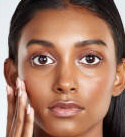

In [17]:
# sample image of normal skin
normal_skin = list(data_dir.glob('normal skin/*'))
PIL.Image.open(str(normal_skin[0]))

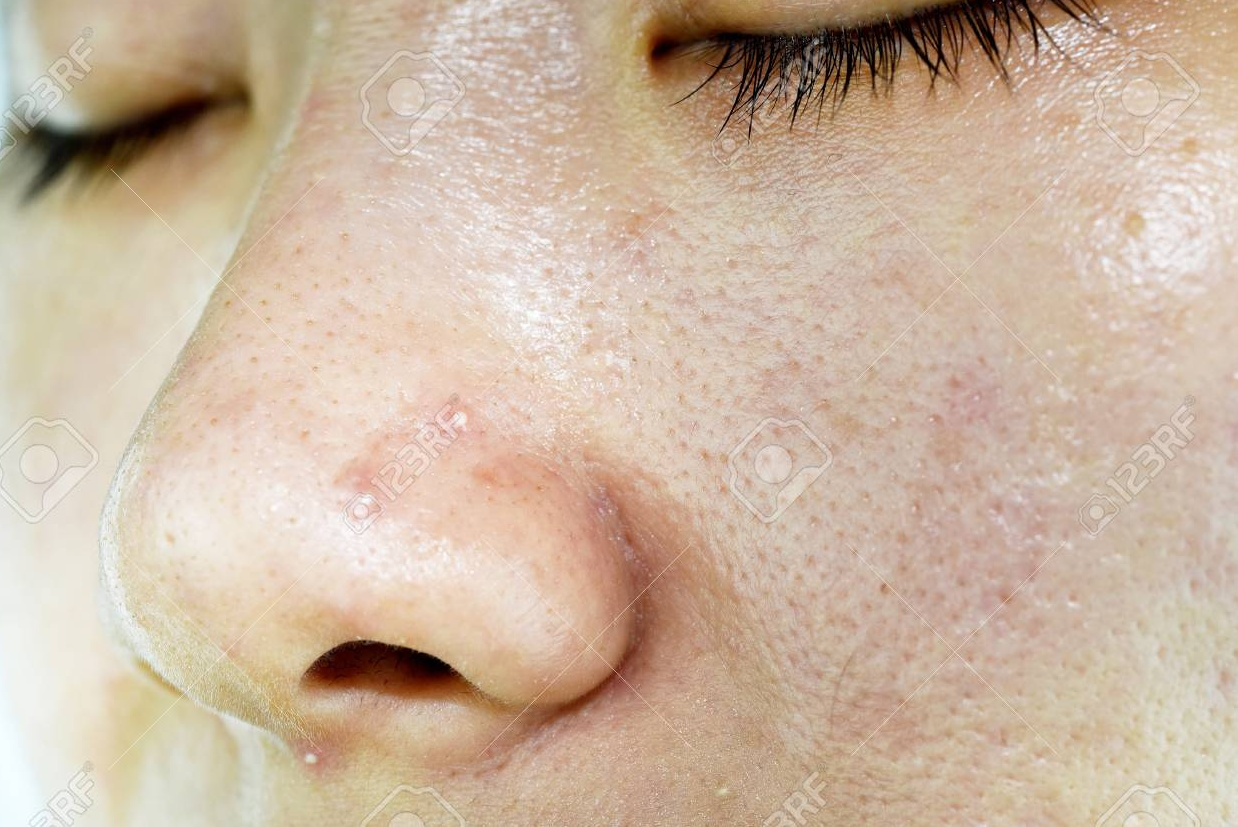

In [18]:
# sample image of oily_skin
oily_skin= list(data_dir.glob('oily skin/*'))
PIL.Image.open(str(oily_skin[0]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory].This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

## Create a dataset

Define some parameters for the loader:

In [19]:
# pre initializing the certain parameters for pre-defining size of the images 
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [20]:
# creatng training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 260 files belonging to 2 classes.
Using 208 files for training.


In [21]:
# creating a validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 260 files belonging to 2 classes.
Using 52 files for validation.


In [22]:
# class_labels
class_names = train_ds.class_names
print(class_names)

['normal skin', 'oily skin']


## Visualize the data

Here are the first 9 images from the training dataset.

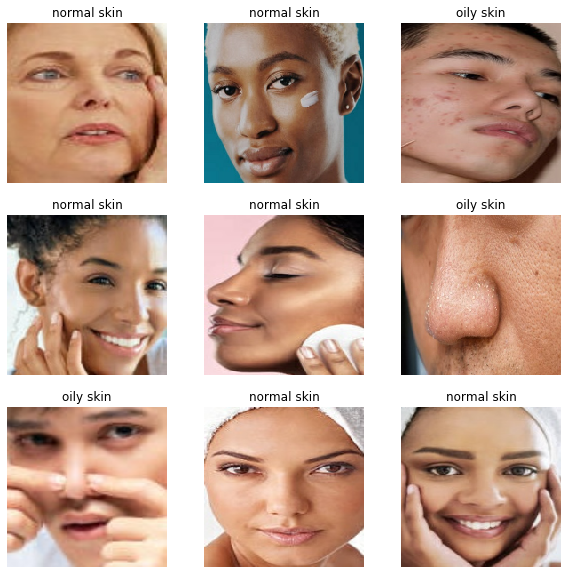

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [25]:
# tuning the data
AUTOTUNE =tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [26]:
# normalization layer for rescaling the images 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9415011


## Data augmentation

Overfitting generally occurs when there are a small number of training examples. "Data augmentation" takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

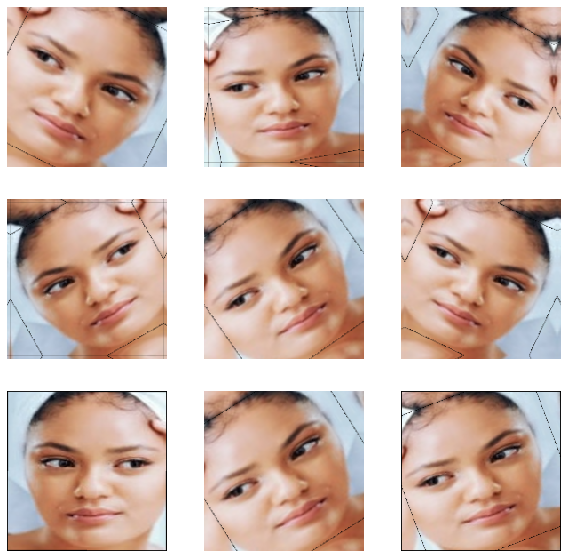

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

## Dropout

Another technique to reduce overfitting is to introduce "Dropout" to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [30]:
num_classes=2
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/500
7/7 [==============================] - 4s 620ms/step - loss: 1.5371 - accuracy: 0.4952 - val_loss: 0.6825 - val_accuracy: 0.6346
Epoch 2/500
7/7 [==============================] - 4s 534ms/step - loss: 0.6947 - accuracy: 0.4856 - val_loss: 0.6834 - val_accuracy: 0.5962
Epoch 3/500
7/7 [==============================] - 4s 537ms/step - loss: 0.6946 - accuracy: 0.5240 - val_loss: 0.6938 - val_accuracy: 0.4038
Epoch 4/500
7/7 [==============================] - 4s 508ms/step - loss: 0.6911 - accuracy: 0.5240 - val_loss: 0.6859 - val_accuracy: 0.5769
Epoch 5/500
7/7 [==============================] - 4s 525ms/step - loss: 0.6883 - accuracy: 0.5337 - val_loss: 0.6737 - val_accuracy: 0.6923
Epoch 6/500
7/7 [==============================] - 3s 496ms/step - loss: 0.6673 - accuracy: 0.7019 - val_loss: 0.6496 - val_accuracy: 0.6346
Epoch 7/500
7/7 [==============================] - 3s 485ms/step - loss: 0.6541 - accuracy: 0.6154 - val_loss: 0.5992 - val_accuracy: 0.7115
Epoch 8/500
7

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

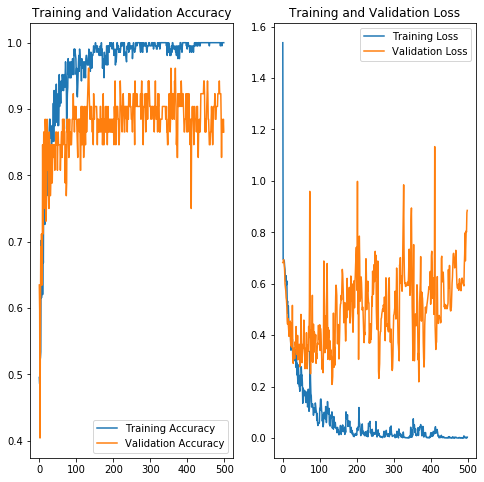

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [41]:
image_paths=['outside_pics/oilyc1.jpeg','outside_pics/normalc1.jpeg']
for i in image_paths:
    img = keras.preprocessing.image.load_img(i, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(i,"Your Face is most likely belongs to {} with a {:.2f} percent confidence.\n".format(class_names[np.argmax(score)], 100 * np.max(score)))
    if class_names[np.argmax(score)]=='oily skin':
        print("you can choose these recommended facewashes :)\n")
        h = open("oily skin facewashes.txt","r")
        for line in h:
            print (line)
        h.close()
    elif class_names[np.argmax(score)]=='normal skin':
        print("you can choose these recommended face washes :)\n")
        h = open("normal skin fashwashes.txt", "r")
        for line in h:
            print (line)
        h.close()

outside_pics/oilyc1.jpeg Your Face is most likely belongs to oily skin with a 99.87 percent confidence.

you can choose these recommended facewashes :)

Plum Green Tea Pore Cleansing Face Wash

Biotique BIO Honey Gel Face Wash 

Natural Vibes ~ Ayurvedic Tea Tree Face Wash

Forest Essentials Mashobra Honey, Lemon and Rosewater Facial Cleanser

outside_pics/normalc1.jpeg Your Face is most likely belongs to normal skin with a 100.00 percent confidence.

you can choose these recommended face washes :)

Himalaya Herbals Purifying Neem Face Wash	

Neutrogena Deep Clean Facial Cleanser	

St. Botanica Vitamin C Gentle Foaming Brightening Face Wash

Mcaffeine Neem Face Wash	

Pondâ€™s Pure White Anti-Pollution + Purity Face Wash	

Clean & Clear Foaming Face Wash	

Aroma Magic Neem And Tea Tree Face Wash	

Lotus Herbals Tea Tree And Cinnamon Anti-Acne Oil Control Face Wash	

Greenberry Organics Detox Charcoal Face Wash	

Himalaya Herbals Purifying Neem Foaming Face Wash

Plum Green Tea Pore Cle